In [1]:
import gdal
import numpy as np 
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
Rasterimage = '/content/drive/MyDrive/Dataset/for testing purpose.tif' 
outRaster = '/content/drive/MyDrive/Dataset/output.tif'
df = pd.read_csv('/content/drive/MyDrive/Dataset/Checking truth.csv',)
df_data= pd.read_csv('/content/drive/MyDrive/Dataset/Truth_data.csv', sep=';')

ds = gdal.Open(Rasterimage, gdal.GA_ReadOnly)
rows = ds.RasterYSize
cols = ds.RasterXSize
bands = ds.RasterCount
geo_transform = ds.GetGeoTransform()
projection = ds.GetProjectionRef()
print(rows,cols)
print(bands)

2615 3537
3


In [3]:
array = ds.ReadAsArray()

In [4]:
array = np.stack(array,axis=2)
array = np.reshape(array, [rows*cols,bands])
test = pd.DataFrame(array, dtype='int16')

In [5]:
df['labels']= df_data.values

In [6]:
df['labels'].value_counts()

Banana         700
Fresh Field    700
Harvested      700
Name: labels, dtype: int64

In [7]:
data= df.drop(['labels','fid'],axis=1)
label= df['labels']

In [8]:
le= LabelEncoder()
label= le.fit_transform(label)

In [9]:
X_train,X_test,y_train,y_test= train_test_split(data,label,test_size=0.1,random_state=0)

In [10]:
def check_shape(df):
  rows,columns= df.shape
  print('Total number of rows',rows)
  print('Total number of Columns',columns)

In [11]:
print('Shape of training set')
check_shape(X_train)
print('shape of testing set')
check_shape(X_test)

Shape of training set
Total number of rows 1890
Total number of Columns 3
shape of testing set
Total number of rows 210
Total number of Columns 3


In [12]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
clf.score(X_train,y_train)

0.9941798941798942

In [14]:
clf.score(X_test,y_test)

0.9523809523809523

In [15]:
y_pred = clf.predict(X_test)

In [16]:
classi_fication= classification_report(y_test,y_pred)
print(classi_fication)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       0.91      0.96      0.93        70
           2       0.95      0.89      0.92        65

    accuracy                           0.95       210
   macro avg       0.95      0.95      0.95       210
weighted avg       0.95      0.95      0.95       210



In [17]:
confusion= confusion_matrix(y_test,y_pred)
print(confusion)

[[75  0  0]
 [ 0 67  3]
 [ 0  7 58]]


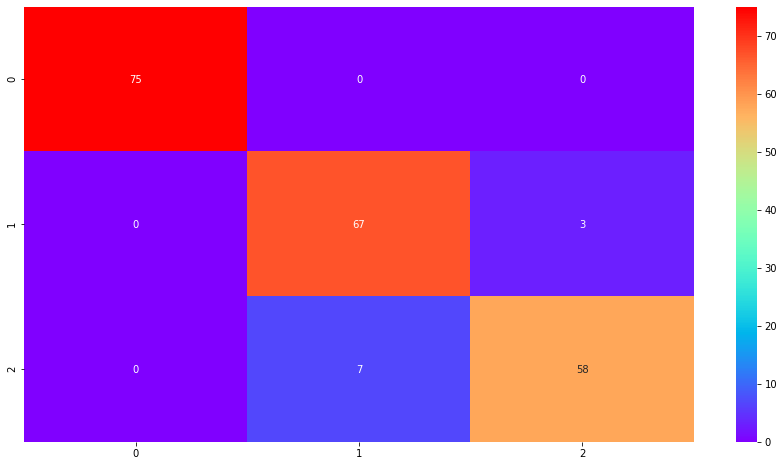

In [18]:
plt.figure(figsize=(15,8))
sns.heatmap(confusion,annot=True,cmap='rainbow');

In [19]:
le.classes_

array(['Banana', 'Fresh Field', 'Harvested'], dtype=object)

In [20]:
real_prediction= clf.predict(test)

In [21]:
classification = real_prediction.reshape((rows,cols))

In [22]:
classification

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 2, 1, 1],
       [0, 0, 0, ..., 2, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]])

In [23]:
def createGeotiff(outRaster, data, geo_transform, projection):
   
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    rasterDS = driver.Create(outRaster, cols, rows, 1, gdal.GDT_Int32)
    rasterDS.SetGeoTransform(geo_transform)
    rasterDS.SetProjection(projection)
    band = rasterDS.GetRasterBand(1)
    band.WriteArray(data)
    rasterDS = None


In [25]:
createGeotiff(outRaster,classification,geo_transform,projection)